In [1]:
import numpy as np
import pandas as pd
import time
from scipy.io import wavfile
from skimage import util
from scipy import signal

#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

#from sklearn.cluster import KMeans
#from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

In [2]:
file_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/535.wav'

In [3]:
def create_slice_from_wav(file_path, slice_len, step_size):
    """Creates small slices from wav file. Slice_len (use sampling frequency to convert to ms). 
    Step_size is amount of overlap between each slice."""
    
    #read in wav file
    samp_freq, sig_data = wavfile.read(file_path)
    print('Sampling frequency: ' + str(samp_freq))
    
    #determine number of samples and length
    n_samples = sig_data.shape[0]
    print('Number of samples: ' + str(n_samples))
    sig_len = n_samples/samp_freq
    print('Length: ' + str(sig_len) + ' sec')
    
    #create slices 
    M = slice_len
    steps = int(M*step_size)
    slices = util.view_as_windows(sig_data, window_shape=(M,), step=steps)
    print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
    
    return samp_freq, sig_data, slices, steps

In [4]:
samp_freq, sig_data, slices, steps = create_slice_from_wav(file_path, 25000, 0.5)

Sampling frequency: 250000
Number of samples: 180748288
Length: 722.993152 sec
Audio shape: (180748288,), Sliced audio shape: (14458, 25000)


In [5]:
start = time.time()
spec_window = 128
NFFT = 256
samp_freq_kHz = samp_freq/1000
i = 0
spec_slices = {}
spec_slices_ravel = {}

for i in range(slices.shape[0]):
    
    #spectrogram
    freqs_spec, times, Sx = signal.spectrogram(slices[i,:], fs=samp_freq, nperseg = spec_window, nfft = NFFT)
    
    #psd
    #freqs_psd, Px = create_psd_from_slice(sli)
    
    #plot spectrogram
    #plt_spec = plot_spec(Sx, times, steps, i)
    
    #plot spd
    #plt_psd = plot_psd(Px, freqs_psd)
    
    time_stamp = i*steps / samp_freq_kHz
    
    spec_slices[time_stamp] = Sx
    spec_slices_ravel[time_stamp] = spec_slices[time_stamp].ravel().T
    
    #psd_slices[i] = np.log10(Px)
    #psd_slices_ravel[i] = Px[i].ravel().T
    
end = time.time()
print(end - start)

76.75197124481201


In [6]:
spec_slices_df = pd.DataFrame(spec_slices_ravel).T
spec_slices_df.head()

,0,1,2,3,4,5,6,7,8,9,...,28757,28758,28759,28760,28761,28762,28763,28764,28765,28766
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034791,0.157594,0.029311,0.154757,0.025271,0.277930,0.088891,0.031531,0.048322,0.043249
50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.082405,0.036593,0.106401,0.242589,0.012758,0.078751,0.040824,0.016307,0.014834,0.000645
100.0,1.385256,2.980197,36.400345,14.312963,23.864168,1.566864,12.290141,1.026281,32.817505,48.472214,...,0.008817,0.037948,0.169130,0.091708,0.099464,0.039362,0.032758,0.117893,0.003960,0.020596
150.0,0.083579,0.001476,0.529463,0.079701,0.013763,0.018957,0.004640,0.000028,0.188468,0.125065,...,0.063076,0.015227,0.036046,0.000057,0.024948,0.203080,0.005172,0.207238,0.007058,0.004882
200.0,0.180176,1.819653,0.034224,0.291076,2.933878,0.086449,0.075673,0.000282,1.937228,1.276914,...,0.002087,0.050329,0.099865,0.000478,0.146562,0.077276,0.037211,0.035421,0.004569,0.026114


In [9]:
spec_slices_thresh_df = pd.DataFrame(index = spec_slices_df.index)
for time_stamp in spec_slices_df.index:
    threshold = np.percentile(spec_slices_df.loc[time_stamp], 70)
    spec_slices_thresh_df.loc[time_stamp][spec_slices_df.loc[time_stamp] < threshold] = 0
    
spec_slices_thresh_df.head()    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


KeyboardInterrupt: 

In [10]:
power_sum_df = pd.DataFrame(index = spec_slices_df.index, columns = ['time_stamp', 'power_sum'])
for time_stamp in spec_slices_df.index:
    power_sum_df.loc[time_stamp]['power_sum'] = spec_slices_df.loc[time_stamp].sum()
    power_sum_df.loc[time_stamp]['time_stamp'] = time_stamp
print(power_sum_df.shape)
power_sum_df.tail()

KeyboardInterrupt: 

In [ ]:
plt.hist(power_sum_df['power_sum'].values, bins = 1000)
plt.show()

In [ ]:
threshold_power = np.percentile(power_sum_df['power_sum'].values, 99)
print(threshold_power)
power_sum_df_thresh = power_sum_df[power_sum_df['power_sum'] > threshold_power]
print(power_sum_df_thresh.shape)
power_sum_df_thresh.head()

In [ ]:
time_stamp_list = power_sum_df_thresh.index.values

In [ ]:
import math
def facet_plot(image_df, time_stamp_list):
    plt.figure(figsize = (20,20))
    plot_row_num = math.ceil(math.sqrt(len(time_stamp_list)))
    plot_col_num = math.ceil(len(time_stamp_list) / plot_row_num)
    for idx, time_stamp in enumerate(time_stamp_list):
        plt.subplot(plot_row_num, plot_col_num, idx+1)
        plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(image_df[time_stamp]))
    plt.show()

In [ ]:
facet_plot(spec_slices, time_stamp_list)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, whiten=True)
X_transformed = pca.fit_transform(np.log(spec_slices_df.iloc[2:]))

In [39]:
spec_slices_df.iloc[2:].shape

(14456, 28767)

In [23]:
freq_count, time_count = spec_slices[50].shape
freq_count

129

In [48]:
X_transformed[1]

array([ 0.96803969,  0.19833084, -0.13370482,  4.65924793, -0.03867947,
        1.73695315,  3.42245335,  2.67461458,  0.44029925,  0.48127456,
        2.38362332, -1.0366536 , -1.30560745, -1.92395718, -0.21341842,
        0.7544693 , -0.35239074, -0.08766005,  0.6915656 , -0.121395  ,
       -0.78896175, -0.37258479,  1.15702154,  0.27338027,  0.03760558,
       -0.05648207,  0.67270252, -1.09613542,  0.53419434, -0.99718542])

In [15]:
pca.components_.shape

(30, 28767)

In [42]:
pca.explained_variance_ratio_

array([0.06824728, 0.01365327, 0.01279538, 0.00685597, 0.00458585,
       0.0043983 , 0.00366129, 0.00285395, 0.00244489, 0.00238255,
       0.00185031, 0.0015599 , 0.00127939, 0.00107613, 0.00104156,
       0.00099758, 0.00097287, 0.00090971, 0.00088467, 0.00082385,
       0.0007183 , 0.00065216, 0.00060959, 0.00058174, 0.00054385,
       0.00050027, 0.00048558, 0.00047999, 0.00045894, 0.0004371 ])

Text(0.5,1,'Singular values')

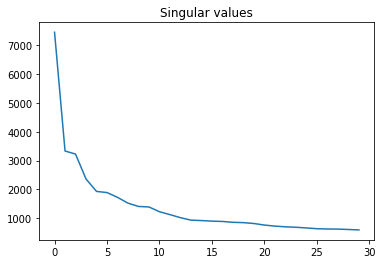

In [43]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

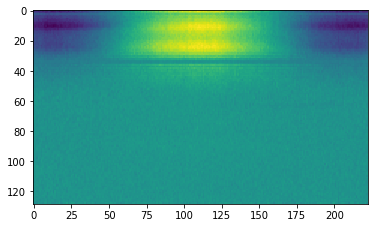

In [34]:
u = pca.components_[:,:].reshape(30,-1,time_count)
plt.imshow(u[3])

ValueError: num must be 1 <= num <= 25, not 26

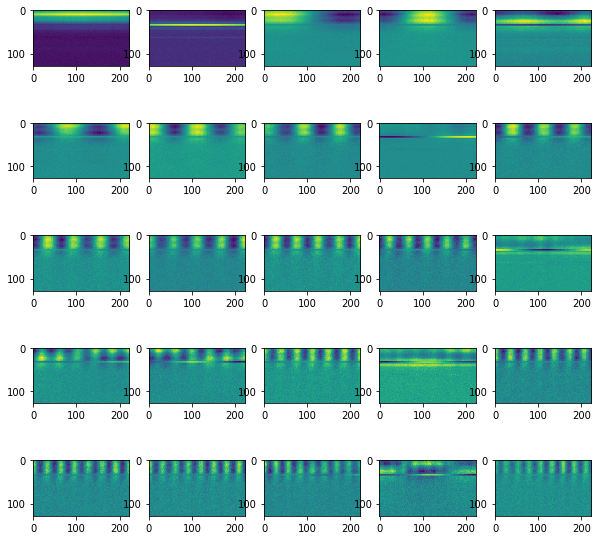

In [45]:
plt.figure(figsize = (10,10))
for i in range(30):
    plt.subplot(5,5,i+1)
    plt.imshow(u[i])

In [14]:
# plot first ten components
plt.figure(figsize = (10,5))
m = 60
spec_dim = [60,59]
u = pca.components_[:,:].reshape(30,-1,m-1)
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((np.squeeze(np.flipud(u[i,:,:])-u.min()))/(u.max() - u.min()), vmin = 0, vmax = 1,cmap = 'viridis')
    #PlotSpecgram(u[i,:,:],freqs[:m],bins)
    plt.title('Mode '+str(i+1))

ValueError: cannot reshape array of size 863010 into shape (30,newaxis,59)

<Figure size 720x360 with 0 Axes>

In [ ]:
# center and scale the data
scaler = StandardScaler()
slices_scaled = scaler.fit_transform(spec_slices_df)

In [ ]:
k_range = range(2,20)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(slices_scaled)
    scores.append(silhouette_score(slices_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=3,random_state=1234)
km2.fit(slices_scaled)
score = silhouette_score(slices_scaled, km_ss.labels_)
#summary_ave['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

In [ ]:
def plot_spec(Sx, times, steps, time_stamp):
    """Plots a spectrogram from a slice"""
    
    f, ax = plt.subplots()
    plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(Sx))
    ax.ticklabel_format(useOffset=False)
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [msec]')
    plt.show()
    
    return plt